## Analysis of Translation Efficiencies

### 1 Data import

In [1]:
import cPickle as pkl
import collections as col
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use("pgf")
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
#matplotlib.style.use('ggplot')
matplotlib.style.use('bmh')

pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [u'Adobe Caslon Pro'],                   # use latex default serif font
    "font.sans-serif": ["Consolas"], # use a specific sans-serif font
}
matplotlib.rcParams.update(pgf_with_rc_fonts)

from statsmodels.nonparametric.smoothers_lowess import lowess

To update the TEs, run https://github.com/gittenberg/TRSL/blob/master/workbooks/analyses/06%20TRSL_time-resolved_single-gene_analyses.ipynb first.

In [3]:
time_tes = pd.read_pickle("../../parameters/te_time-resolved.p") # pkl.load(open("../../parameters/te_time-resolved.p"))
init_rates = pd.read_pickle("../../parameters/init_rates_plotkin.p") # pkl.load(open("../../parameters/init_rates_plotkin.p"))

In [4]:
time_tes.head()

0         300       600       900       1200      1500      1800  \
YAL001C  0.026667  0.023333  0.010833  0.015000  0.018333  0.036667  0.040000   
YAL002W  0.013333       NaN  0.011667  0.008333  0.006667  0.015000  0.013333   
YAL003W  0.142579  0.143810  0.098534  0.098801  0.104697  0.198377  0.197895   
YAL005C  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
YAL007C  0.054167  0.061111  0.033788  0.038889  0.038333  0.094444  0.097778   

             2100      2400      2700      3000      3300  
YAL001C       NaN  0.036667  0.033333       NaN  0.043333  
YAL002W  0.026667  0.005000  0.021667       NaN  0.013333  
YAL003W  0.201111  0.202593  0.202376  0.242971  0.192971  
YAL005C  0.000000  0.000000  0.000000  0.000000  0.000000  
YAL007C  0.088333  0.100833  0.098333  0.131667  0.076111

In [5]:
annotations = pd.DataFrame.from_csv('../../data/sce_Nagaraj.tsv', sep='\t', header=1)

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


How many can we work with:

In [6]:
print time_tes.shape
print len(init_rates.keys())
print len(annotations.index)
print len(time_tes.transpose().to_dict().viewkeys() & init_rates.viewkeys())

(5575, 12)
4839
3794
4605


### 2 Translation efficiencies vs initiation rates over the cycle

In [7]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [8]:
def scatter_dicts(dict1, dict2, lowess=True, logaxis=True, xaxislabel=None, yaxislabel=None, fontsize=None, alpha=0.2):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    if logaxis:
        ax.set_xscale('log')
        ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
    if fontsize:
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(alpha)

    if lowess:
        points = zip(xs, ys)
        sorted_points = sorted(points)
        new_xs = [point[0] for point in sorted_points]
        new_ys = [point[1] for point in sorted_points]
        ylowess = lowess(new_ys, new_xs)[:,1]
        plt.plot(new_xs, ylowess, 'orange', linewidth=4)

4605


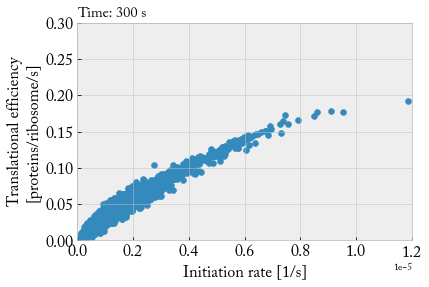

4605


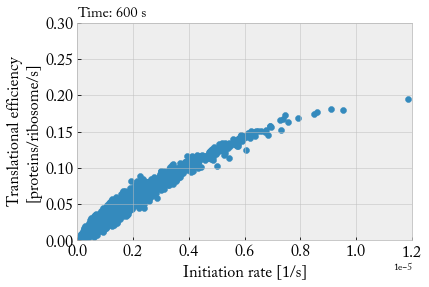

4605


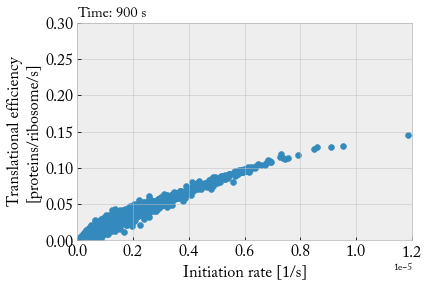

4605


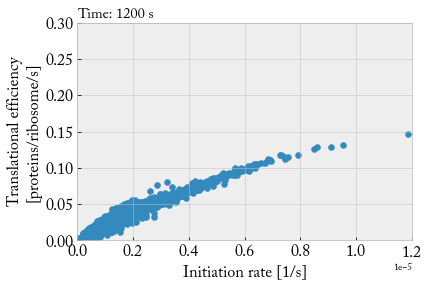

4605


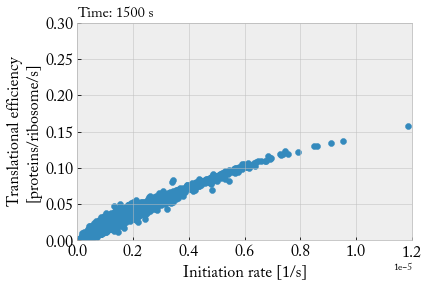

4605


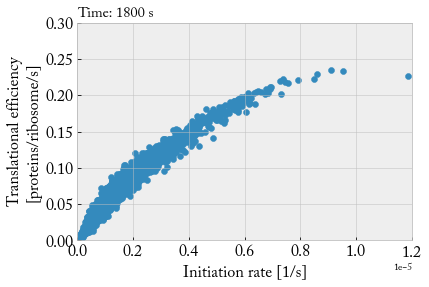

4605


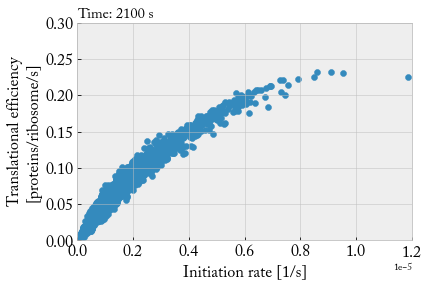

4605


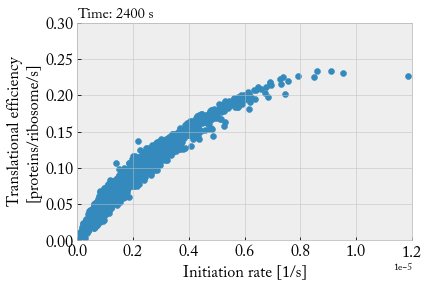

4605


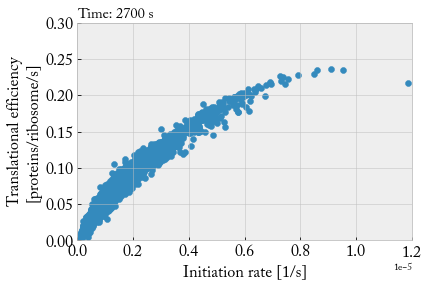

4605


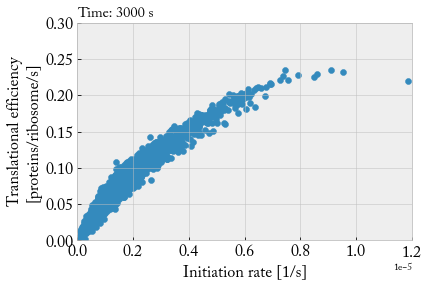

4605


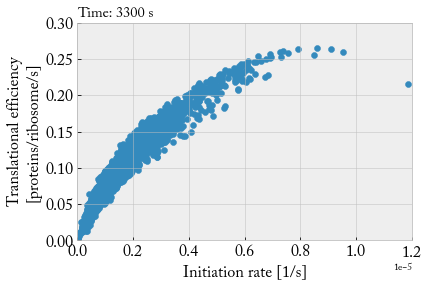

4605


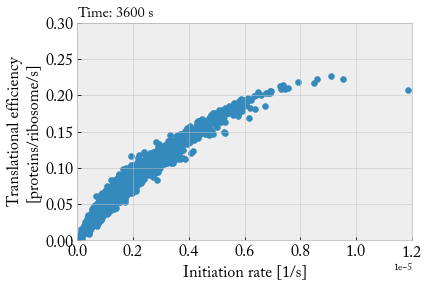

In [9]:
for time in time_tes.columns:
    scatter_dicts(init_rates, time_tes[time].to_dict(), logaxis=False, lowess=False, xaxislabel='Initiation rate [1/s]', 
                  yaxislabel='Translational efficiency\n[proteins/ribosome/s]', fontsize=16, alpha=1.0)
    plt.title('Time: {} s'.format(time+300), loc='left')
    plt.xlim([1e-8, 1.2e-5])
    plt.ylim([0.0, 0.3])
    plt.locator_params(axis='x',nbins=10)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.show()

### 3 Same but with annotation and color

In [10]:
mincount = 50

In [11]:
all_annotations = pkl.load(open("../../parameters/annotations_liebermeister.p", "rb"))
annotations = {k: v for k, v in all_annotations.items() if v}  # remove empty values
all_functional_categories = col.Counter(annotations.values())
functional_categories = col.Counter({k: v for k, v in all_functional_categories.items() if v >= mincount})
annotations = {k: v for k, v in annotations.items() if v in functional_categories}

In [12]:
categories_used = len(functional_categories)
functional_categories

Counter({'Amino acid metabolism': 119,
         'Chaperones and folding catalysts': 63,
         'Chromosome-related': 113,
         'Cofactor biosynthesis': 82,
         'Glycolysis': 54,
         'Lipid and steroid metabolism': 67,
         'Other enzymes': 124,
         'Ribosome': 110,
         'Ribosome biogenesis in eukaryotes': 55,
         'Spliceosome': 54})

Comparing all annotations with those that have the minimum count:

In [13]:
# intersection
anno_keys = init_rates.viewkeys() & time_tes.transpose().to_dict().viewkeys() & all_annotations.viewkeys()
print len(anno_keys)

3472


In [14]:
plotkeys = init_rates.viewkeys() & time_tes.transpose().to_dict().viewkeys() & annotations.viewkeys() # intersection
print len(plotkeys)

725


In [15]:
time_tes_by_function = {}
init_rates_by_function = {}

for time in time_tes.columns:
    time_tes_by_function[time] = {}

    for function in functional_categories.keys():
        init_rates_by_function[function] = [init_rates[key] for key in plotkeys if annotations[key]==function]
        time_tes_by_function[time][function] = [time_tes[time].to_dict()[key] for key in plotkeys 
                                                if annotations[key]==function]

#### Checking and sorting the means

In [16]:
import operator
sorted_functions = sorted({function: np.nanmean(time_tes_by_function[300][function]) 
                           for function in time_tes_by_function[300]}.items(), 
                           key=operator.itemgetter(1),
                           reverse=True)
sorted_functions

[('Ribosome', 0.12347853664006646),
 ('Glycolysis', 0.08240811388488108),
 ('Chaperones and folding catalysts', 0.06883933492560936),
 ('Amino acid metabolism', 0.06100709608344855),
 ('Ribosome biogenesis in eukaryotes', 0.05363906469045359),
 ('Lipid and steroid metabolism', 0.050389449311934384),
 ('Other enzymes', 0.049375855737671406),
 ('Spliceosome', 0.04907013658176449),
 ('Cofactor biosynthesis', 0.047231588255929956),
 ('Chromosome-related', 0.0391216537151836)]

Looks good.

#### Plotting

We assign colors to the functions:

In [17]:
colordict = {function[0]: cm.Paired(i) for i, function in enumerate(sorted_functions)}

The last 2 look ugly and are replaced manually:

In [18]:
#colordict['Glycan metabolism'] = (0.4, 0.4, 0.4, 1.0)
#colordict['Chromosome-related'] = (1.0, 1.0, 1.0, 0.0)

Some manual adjustments:

In [19]:
colordict['Ribosome'], colordict['Lipid and steroid metabolism'] = \
colordict['Lipid and steroid metabolism'], colordict['Ribosome']

#colordict['Glycan metabolism'], colordict['Chaperones and folding catalysts'] = \
#colordict['Chaperones and folding catalysts'], colordict['Glycan metabolism']

In [20]:
colordict

{'Amino acid metabolism': (0.2, 0.6274509803921569, 0.17254901960784313, 1.0),
 'Chaperones and folding catalysts': (0.6980392156862745,
  0.8745098039215686,
  0.5411764705882353,
  1.0),
 'Chromosome-related': (0.41568627450980394,
  0.23921568627450981,
  0.6039215686274509,
  1.0),
 'Cofactor biosynthesis': (0.792156862745098,
  0.6980392156862745,
  0.8392156862745098,
  1.0),
 'Glycolysis': (0.12156862745098039,
  0.47058823529411764,
  0.7058823529411765,
  1.0),
 'Lipid and steroid metabolism': (0.6509803921568628,
  0.807843137254902,
  0.8901960784313725,
  1.0),
 'Other enzymes': (0.9921568627450981,
  0.7490196078431373,
  0.43529411764705883,
  1.0),
 'Ribosome': (0.8901960784313725,
  0.10196078431372549,
  0.10980392156862745,
  1.0),
 'Ribosome biogenesis in eukaryotes': (0.984313725490196,
  0.6039215686274509,
  0.6,
  1.0),
 'Spliceosome': (1.0, 0.4980392156862745, 0.0, 1.0)}

We create several series and scatter on top of each other.

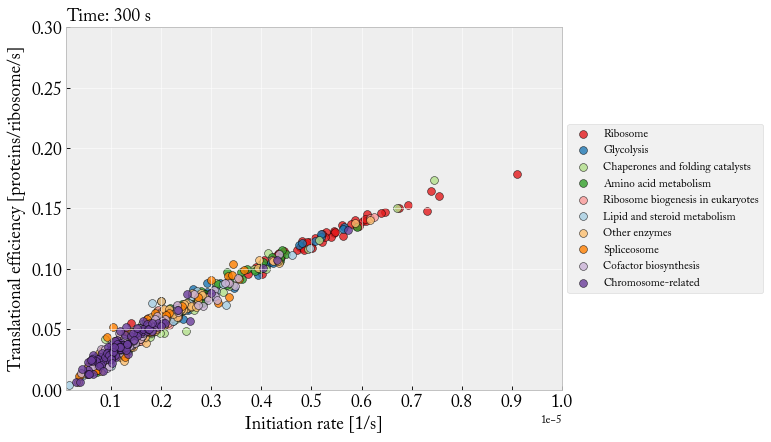

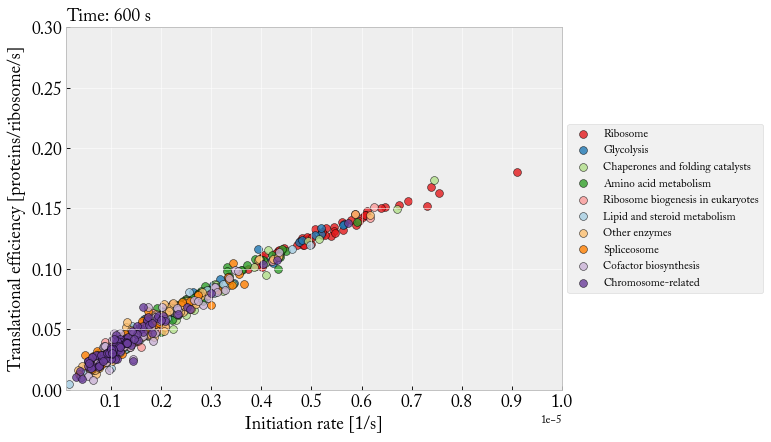

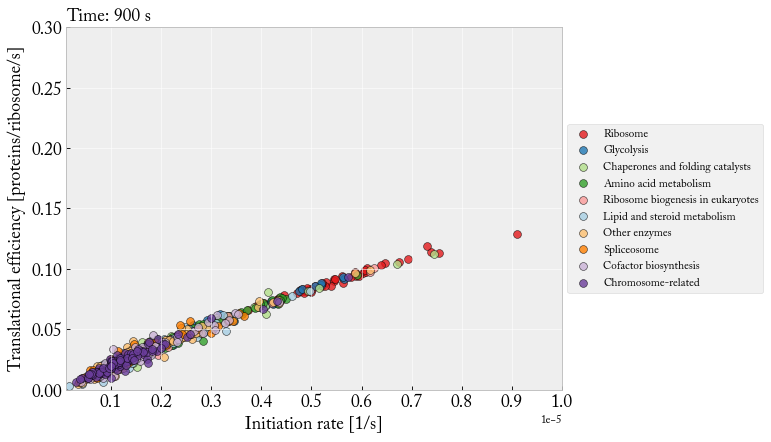

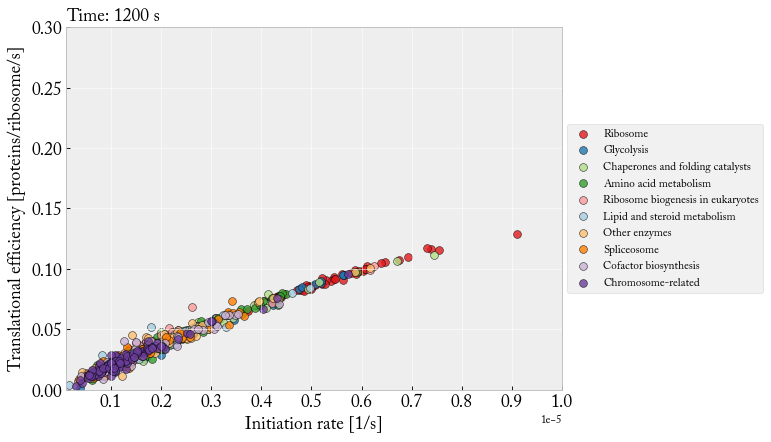

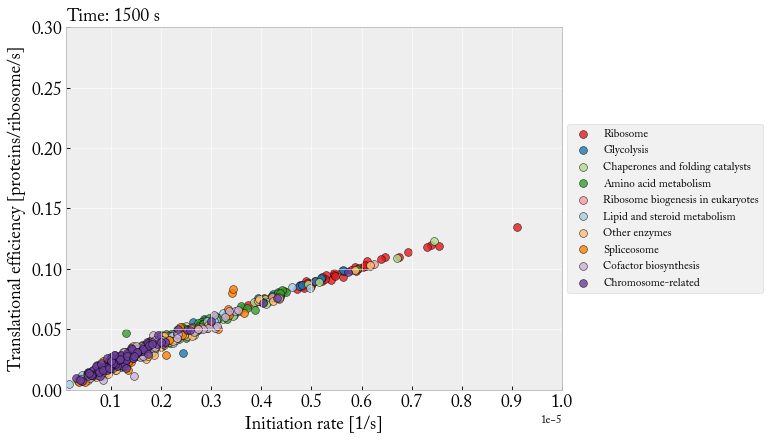

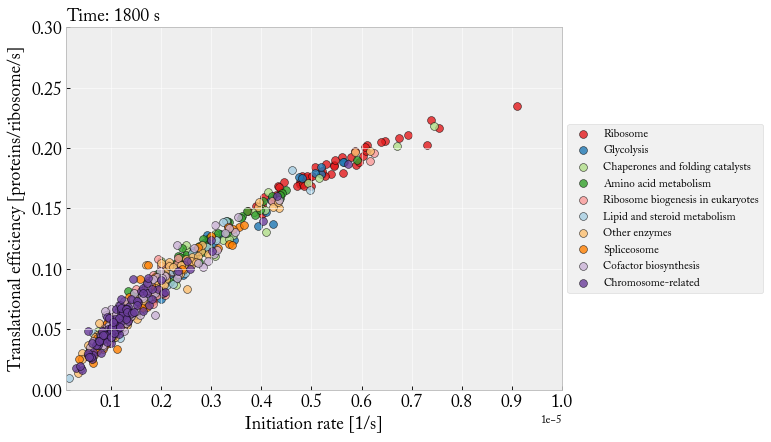

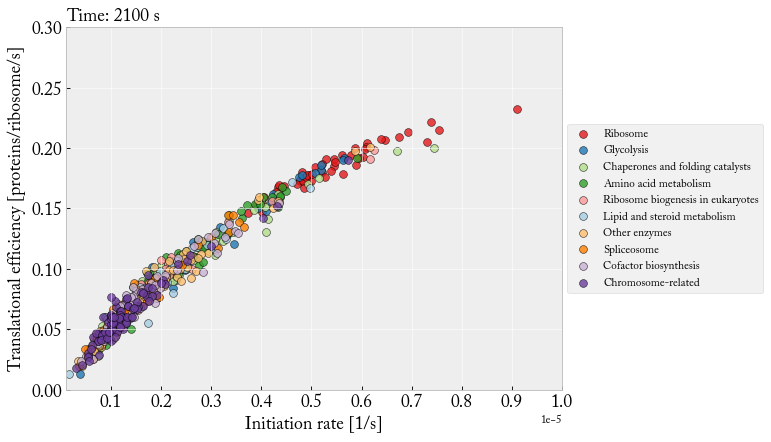

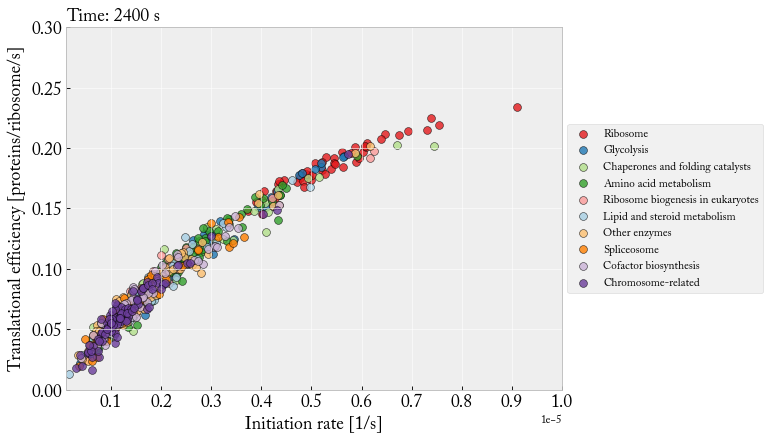

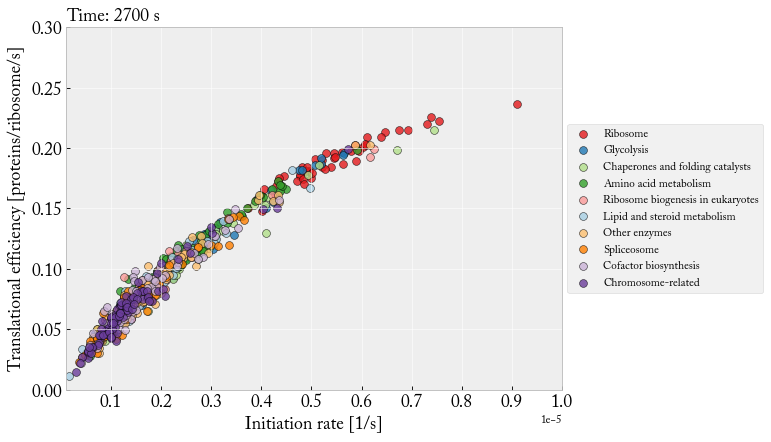

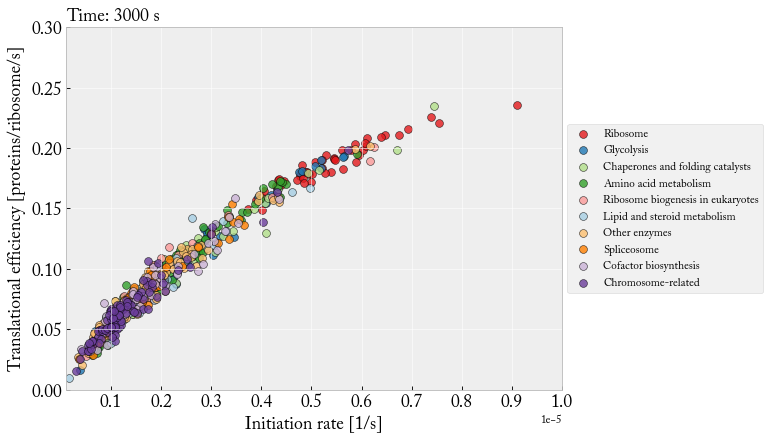

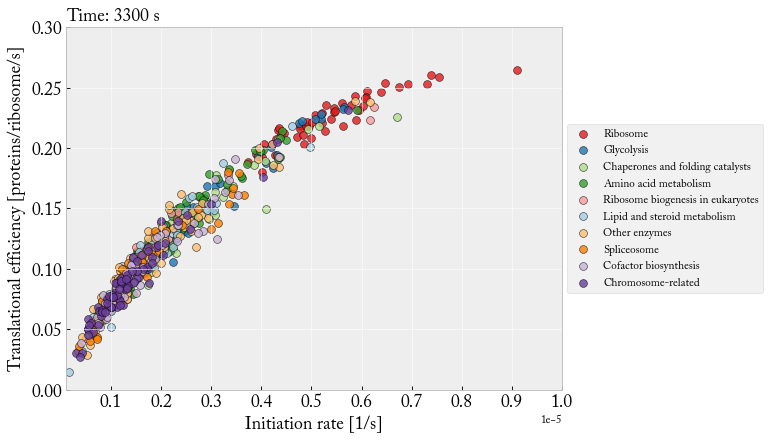

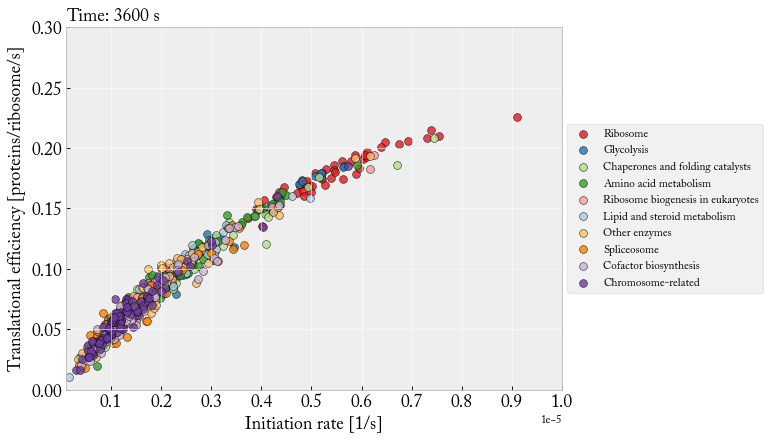

In [21]:
fontsize = 16

xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency [proteins/ribosome/s]'

for time in time_tes.columns:
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w')                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '1.0')

    for function, _ in sorted_functions:
        scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], 
                           c=colordict[function],
                           label=function, 
                           s=50, 
                           edgecolor='black')
        scat.set_alpha(0.8)

    plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
    plt.xlim([1e-7, 1.0e-5])
    plt.ylim([0.0, 0.3])
    plt.locator_params(axis='x',nbins=10)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xlabel(xaxislabel)
    ax.set_xlabel(xaxislabel, fontsize=fontsize)
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    ax.set_ylabel(yaxislabel)
    ax.set_ylabel(yaxislabel, fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

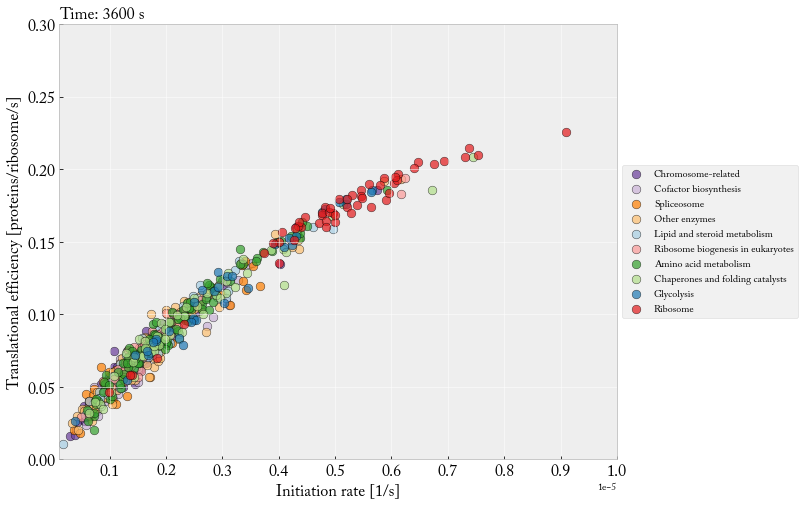

In [22]:
plt.rcParams['figure.figsize'] = (10, 8)

fontsize = 16
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency [proteins/ribosome/s]'

fig =  plt.figure()                

ax = fig.add_subplot(111)
ax.grid(True, linestyle = '-', color = '1.0')

for function, _ in sorted_functions[::-1]:
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], 
                       c=colordict[function],
                       label=function, 
                       s=75, 
                       edgecolor='black')
    scat.set_alpha(0.7)
    
plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

### Plot against time axis

In [23]:
annotations_df = pd.DataFrame.from_dict(annotations, orient='index', dtype=None)
annotations_df.columns = ["Function"]

In [24]:
time_tes_annotated = pd.merge(time_tes, annotations_df, how='inner', on=None, left_on=None, right_on=None,
                              left_index=True, right_index=True, sort=True, copy=True, indicator=False)

In [25]:
time_tes_annotated.head()

0       300       600       900      1200      1500      1800  \
YAL005C  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
YAL011W  0.025000  0.031667  0.025000  0.017778  0.022500       NaN  0.041667   
YAL012W  0.112587  0.114672  0.075221  0.078857  0.080982  0.165161  0.164095   
YAL026C  0.024167  0.016111  0.013333  0.013333  0.014000  0.039167  0.031667   
YAL032C  0.026667  0.045833  0.026667  0.028333  0.024583  0.065000  0.061667   

             2100      2400      2700      3000      3300  \
YAL005C  0.000000  0.000000  0.000000  0.000000  0.000000   
YAL011W  0.061667       NaN  0.065000       NaN  0.045000   
YAL012W  0.167304  0.165707  0.170325  0.206296  0.161124   
YAL026C  0.033333  0.043333  0.043333  0.066667  0.030000   
YAL032C  0.058333       NaN  0.068333       NaN  0.063333   

                                 Function  
YAL005C  Chaperones and folding catalysts  
YAL011W                Chromosome-related  
YAL012W             Amino acid metabolism  
YAL026C                     Other enzymes  
YAL032C                       Spliceosome

In [26]:
print len(time_tes_annotated)
print len(time_tes)
print len(annotations_df)

828
5575
841


Same for the larger set:

In [27]:
all_annotations_df = pd.DataFrame.from_dict(all_annotations, orient='index', dtype=None)
all_annotations_df.columns = ["Function"]

In [28]:
all_time_tes_annotated = pd.merge(time_tes, all_annotations_df, how='inner', on=None, left_on=None, right_on=None,
                              left_index=True, right_index=True, sort=True, copy=True, indicator=False)

In [29]:
all_time_tes_annotated.head()

0       300       600       900      1200      1500      1800  \
YAL001C  0.026667  0.023333  0.010833  0.015000  0.018333  0.036667  0.040000   
YAL003W  0.142579  0.143810  0.098534  0.098801  0.104697  0.198377  0.197895   
YAL005C  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
YAL007C  0.054167  0.061111  0.033788  0.038889  0.038333  0.094444  0.097778   
YAL008W  0.074167  0.083333  0.049167  0.056000  0.055000  0.117500  0.118333   

             2100      2400      2700      3000      3300  \
YAL001C       NaN  0.036667  0.033333       NaN  0.043333   
YAL003W  0.201111  0.202593  0.202376  0.242971  0.192971   
YAL005C  0.000000  0.000000  0.000000  0.000000  0.000000   
YAL007C  0.088333  0.100833  0.098333  0.131667  0.076111   
YAL008W  0.120000  0.130000  0.125000  0.153333       NaN   

                                 Function  
YAL001C                                    
YAL003W               Translation factors  
YAL005C  Chaperones and folding catalysts  
YAL007C                                    
YAL008W

In [30]:
print len(all_time_tes_annotated)
print len(time_tes)
print len(all_annotations_df)

3732
5575
3794


#### Dynamic range

In [31]:
time_tes.max(axis=0, skipna=None, level=None, numeric_only=None)

0       0.192222
300     0.194444
600     0.145833
900     0.146667
1200    0.158333
1500    0.234781
1800    0.232593
2100    0.234028
2400    0.236351
2700    0.235631
3000    0.265000
3300    0.226014
dtype: float64

In [32]:
time_tes.min(axis=0, skipna=True, level=None, numeric_only=True)

0       0.0
300     0.0
600     0.0
900     0.0
1200    0.0
1500    0.0
1800    0.0
2100    0.0
2400    0.0
2700    0.0
3000    0.0
3300    0.0
dtype: float64

In [33]:
all_time_tes_annotated.min(axis=0, skipna=True, level=None, numeric_only=True)

0       0.0
300     0.0
600     0.0
900     0.0
1200    0.0
1500    0.0
1800    0.0
2100    0.0
2400    0.0
2700    0.0
3000    0.0
3300    0.0
dtype: float64

Does not work because of zeros.

#### Plot by function with jitter:

http://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot

In [34]:
def rand_jitter(arr):
    stdev = .0125 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, 
           linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), y, s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, 
                       vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

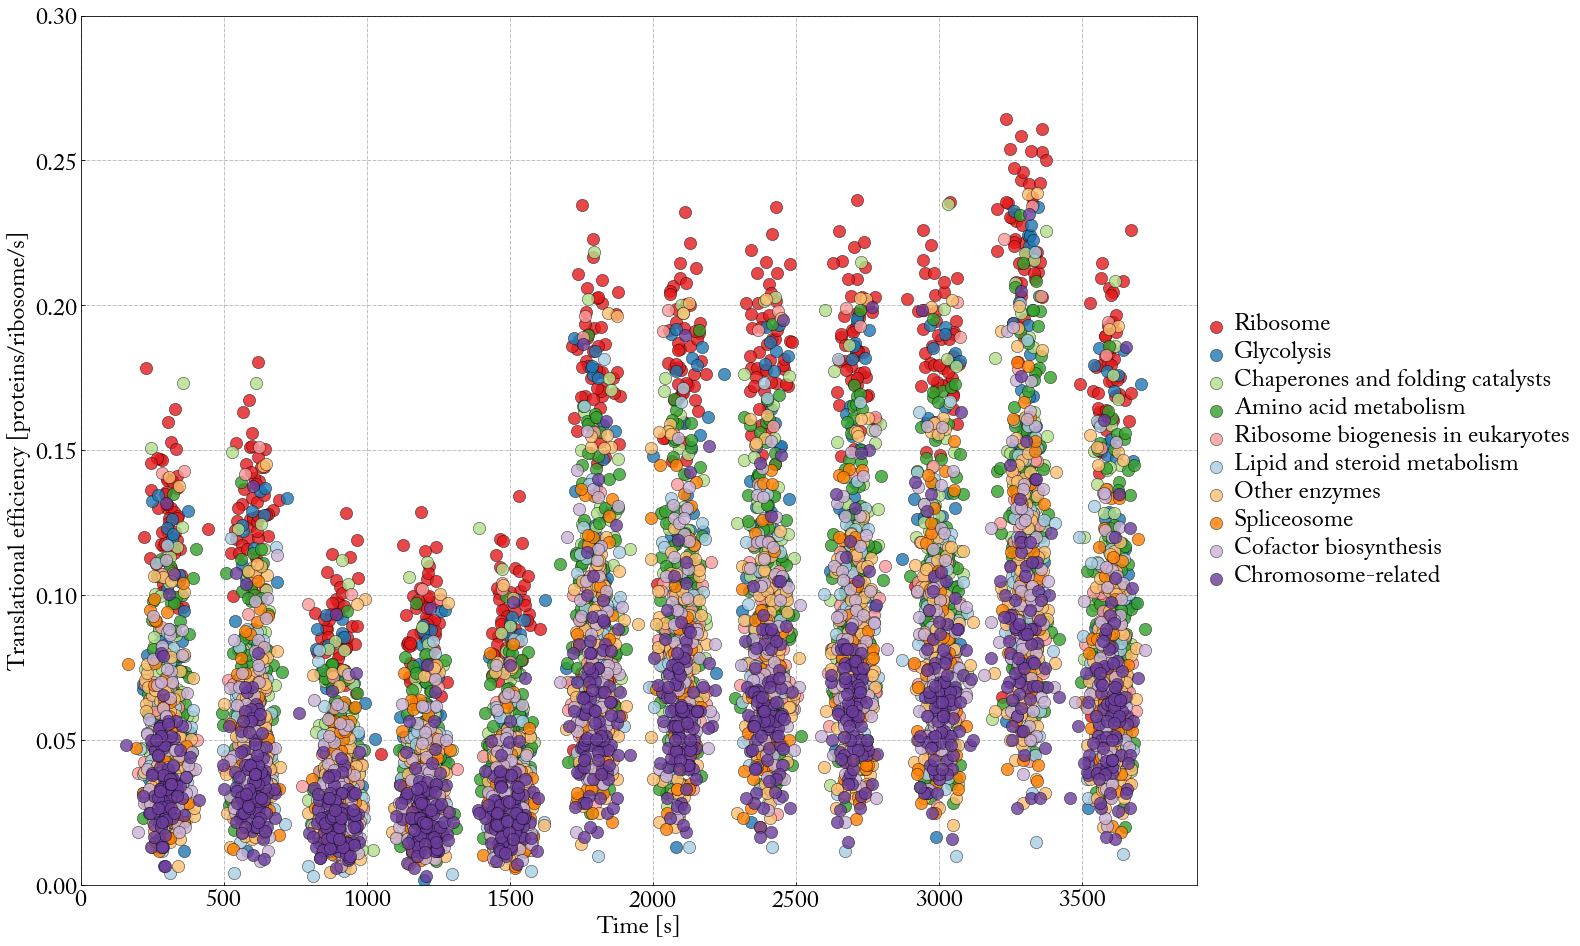

In [36]:
plt.rc('font',family=u'Adobe Caslon Pro')
plt.rcParams['figure.figsize'] = (20, 16)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.labelcolor']='black'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['grid.linestyle']='-.'
plt.rcParams['grid.color']='grey'
#plt.rcParams['figure.facecolor'] = 'white'

hfont = {'fontname': u'Adobe Caslon Pro'}

fig =  plt.figure()                

ax = fig.add_subplot(111, facecolor='white')

fontsize = 24

xaxislabel = 'Time [s]'
yaxislabel = 'Translational efficiency [proteins/ribosome/s]'

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlabel(xaxislabel, **hfont)
ax.set_xlabel(xaxislabel, fontsize=fontsize, **hfont)
plt.setp(ax.get_xticklabels(), fontsize=fontsize, **hfont)
#ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize, **hfont)
plt.setp(ax.get_yticklabels(), fontsize=fontsize, **hfont)

for function, _ in sorted_functions:
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function, s=150, edgecolor='black')
        scat.set_alpha(0.8)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

# sort labels
labels_tmp = [u'Glycolysis', u'Chaperones and folding catalysts',
       u'Amino acid metabolism', u'Ribosome',
       u'Ribosome biogenesis in eukaryotes', u'Lipid and steroid metabolism',
       u'Other enzymes', u'Spliceosome', u'Cofactor biosynthesis',
       u'Chromosome-related']
# sort handles the same way
# https://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list
handles_tmp = [x for _, x in sorted(zip(labels_tmp, handles))]


#shortlabels = list(set(labels))
#print shortlabels

plt.legend(handles_tmp, labels_tmp, loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, facecolor="white", frameon=False)

legend = ax.get_legend()

for i, label in enumerate(sorted_functions):
    legend.legendHandles[i].set_color(colordict[label[0]])
    #legend.legendHandles[i].set_color(colors[i])
    legend.legendHandles[i].set_edgecolor('black')
    legend.get_texts()[i].set_text(label[0])
    legend.get_texts()[i].set_fontsize(fontsize)

#plt.legend(frameon=False)
#for label in legend.get_texts():
#    label.set_fontsize(fontsize)
    
plt.savefig("time_resolved_efficiency.png", bbox_inches='tight')
plt.show()

### Combined in one plot

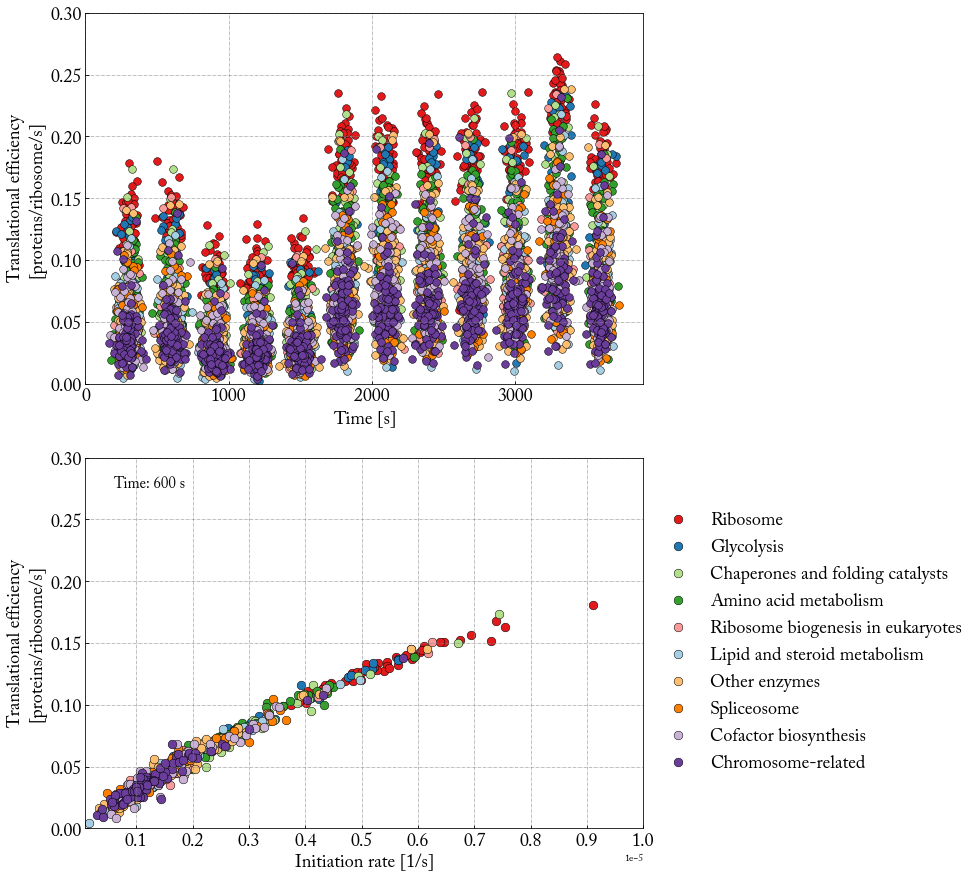

In [38]:
plt.rcParams['figure.figsize'] = (10, 15)

fig =  plt.figure()                

ax = fig.add_subplot(211, facecolor='white')

fontsize = 18
markersize = 60

xaxislabel = 'Time [s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

for function, _ in sorted_functions:
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function, s=markersize, edgecolor='black',
                     rasterized=True)
        scat.set_alpha(1.0)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

shortlabels = list(set(labels))

#plt.text(-350, 0.3, "A", fontsize=24, weight="bold")

ax = fig.add_subplot(212, facecolor='white')

time = 300
#fontsize = 24
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

for function, _ in sorted_functions:
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], 
                       c=colordict[function],
                       label=function, 
                       s=75, 
                       edgecolor='black')
    scat.set_alpha(1.0)
    
#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
ax.text(.05, .92, 'Time: 600 s', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), fontsize=fontsize)
plt.rc('font', **{'size':'24'})

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('time_and_init_rate_resolved_efficiency.png', bbox_inches='tight', dpi=400)
#plt.savefig('time_and_init_rate_resolved_efficiency.pdf', bbox_inches='tight', dpi=400)
#plt.savefig('time_and_init_rate_resolved_efficiency.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

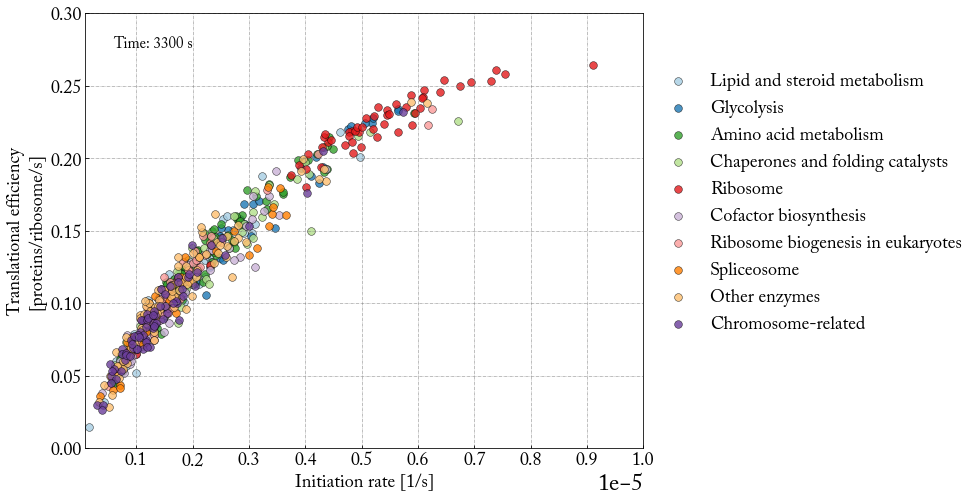

In [39]:
plt.rcParams['figure.figsize'] = (10, 8)

fig =  plt.figure()                

ax = fig.add_subplot(111, facecolor='white')

fontsize = 18
markersize = 60

time = 3000
#fontsize = 24
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

for function in functional_categories.keys():
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], c=colordict[function], 
                       label=function, s=markersize, edgecolor='black', rasterized=True)
    scat.set_alpha(0.8)
    
#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
ax.text(.05, .92, 'Time: 3300 s', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), fontsize=fontsize)
plt.rc('font', **{'size':'24'})

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('efficiency_by_function_and_init_rate.png', bbox_inches='tight', dpi=400)
#plt.show()

For Computer Modern (version for Elsevier):

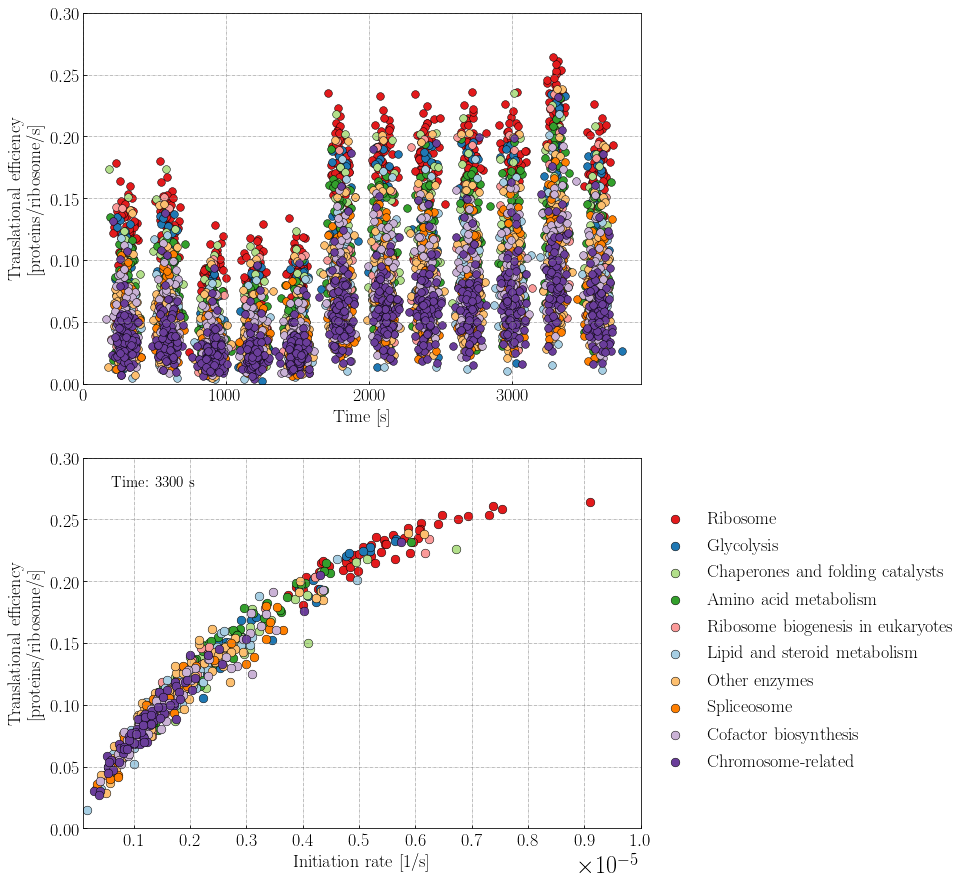

In [41]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams['figure.figsize'] = (10, 15)

fig =  plt.figure()                

ax = fig.add_subplot(211, facecolor='white')

fontsize = 18
markersize = 60

xaxislabel = 'Time [s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

for function, _ in sorted_functions:
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function, s=markersize, edgecolor='black',
                     rasterized=True)
        scat.set_alpha(1.0)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

shortlabels = list(set(labels))

#plt.text(-350, 0.3, "A", fontsize=24, weight="bold")

ax = fig.add_subplot(212, facecolor='white')

time = 3000
#fontsize = 24
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

for function, _ in sorted_functions:
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], 
                       c=colordict[function],
                       label=function, 
                       s=75, 
                       edgecolor='black')
    scat.set_alpha(1.0)
    
#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
ax.text(.05, .92, 'Time: 3300 s', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), fontsize=fontsize)
plt.rc('font', **{'size':'24'})

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('time_and_init_rate_resolved_efficiency.png', bbox_inches='tight', dpi=400)
#plt.savefig('time_and_init_rate_resolved_efficiency.pdf', bbox_inches='tight', dpi=400)
#plt.savefig('time_and_init_rate_resolved_efficiency.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

#### Separate plots

Trick to make labels unique: https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib

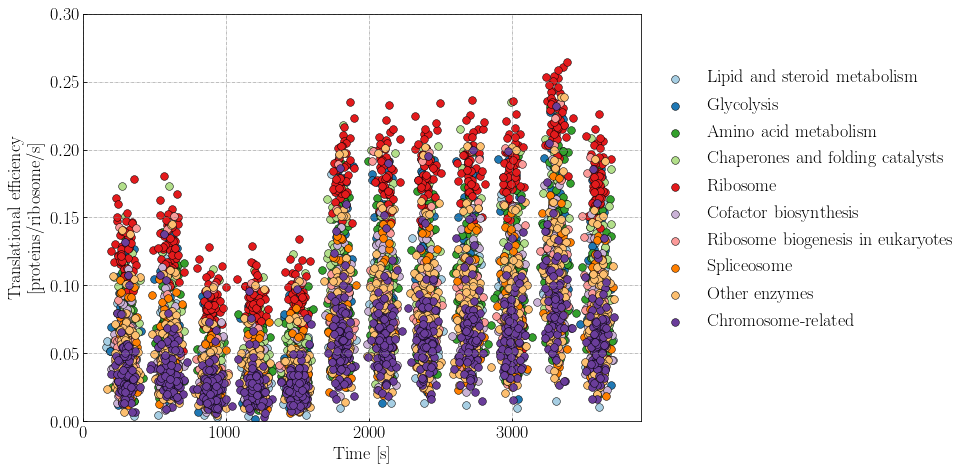

In [43]:
plt.rcParams['figure.figsize'] = (10, 7.5)

fig =  plt.figure()                

ax = fig.add_subplot(111, facecolor='white')

fontsize = 18
markersize = 60

xaxislabel = 'Time [s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

for function in functional_categories.keys():
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function if i == 0 else "", 
                      s=markersize, edgecolor='black', rasterized=True)
        scat.set_alpha(1.0)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

#labels = list(set(labels))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')


#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('time_resolved_efficiency.png', bbox_inches='tight', dpi=400)
#plt.show()

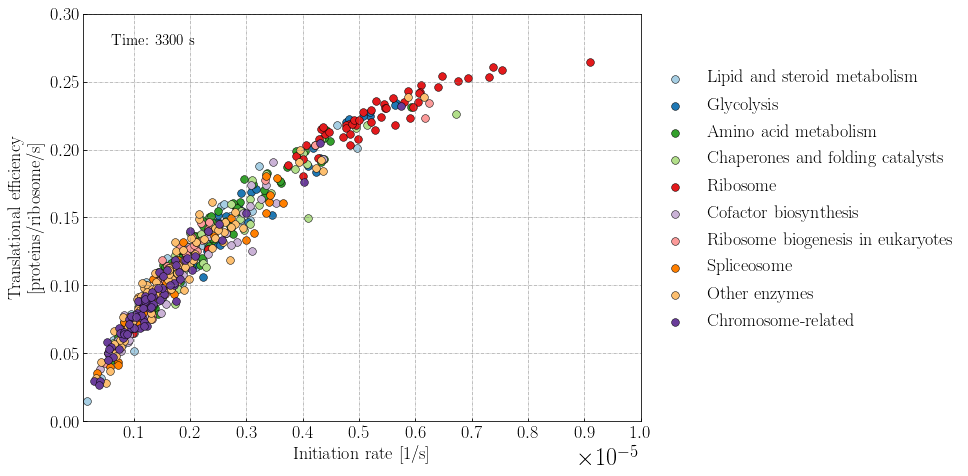

In [44]:
plt.rcParams['figure.figsize'] = (10, 7.5)

fig =  plt.figure()                

ax = fig.add_subplot(111, facecolor='white')

fontsize = 18
markersize = 60

time = 3000
#fontsize = 24
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

for function in functional_categories.keys():
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], c=colordict[function], 
                       label=function, s=markersize, edgecolor='black', rasterized=True)
    scat.set_alpha(1.0)
    
#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
ax.text(.05, .92, 'Time: 3300 s', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), fontsize=fontsize)
plt.rc('font', **{'size':'24'})

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('efficiency_by_function_and_init_rate.png', bbox_inches='tight', dpi=400)
#plt.show()

In [45]:
time_tes_by_function.keys()

[0, 2400, 900, 1800, 2700, 300, 1200, 3000, 2100, 600, 3300, 1500]

In [46]:
time_tes_by_function[0].keys()

['Lipid and steroid metabolism',
 'Glycolysis',
 'Chaperones and folding catalysts',
 'Ribosome',
 'Cofactor biosynthesis',
 'Ribosome biogenesis in eukaryotes',
 'Amino acid metabolism',
 'Spliceosome',
 'Other enzymes',
 'Chromosome-related']

In [47]:
pkl.dump(time_tes_by_function, open("../../parameters/time_tes_by_function.p", "wb"))

In [48]:
pkl.dump(all_time_tes_annotated, open("../../parameters/all_time_tes_annotated.df", "wb"))

In [49]:
all_time_tes_annotated

0       300       600       900      1200      1500  \
YAL001C    0.026667  0.023333  0.010833  0.015000  0.018333  0.036667   
YAL003W    0.142579  0.143810  0.098534  0.098801  0.104697  0.198377   
YAL005C    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
YAL007C    0.054167  0.061111  0.033788  0.038889  0.038333  0.094444   
YAL008W    0.074167  0.083333  0.049167  0.056000  0.055000  0.117500   
YAL010C    0.033333       NaN       NaN  0.018333  0.013333       NaN   
YAL011W    0.025000  0.031667  0.025000  0.017778  0.022500       NaN   
YAL012W    0.112587  0.114672  0.075221  0.078857  0.080982  0.165161   
YAL013W    0.063889  0.057222  0.037778  0.045000  0.042857  0.091667   
YAL014C    0.015000  0.021667  0.012333  0.011333  0.015417       NaN   
YAL016W    0.049667  0.050000  0.032500  0.038333  0.039000  0.093333   
YAL017W         NaN  0.023333  0.010000  0.014583  0.011333  0.031111   
YAL019W    0.029167  0.027500  0.017222  0.017083  0.020000  0.043333   
YAL021C    0.035000  0.034167  0.020833  0.025000  0.022500  0.048333   
YAL023C    0.041429  0.032778  0.022157  0.024242  0.025859  0.058056   
YAL024C    0.025000  0.016667       NaN  0.011111  0.012000  0.013333   
YAL025C    0.107778  0.110833  0.082222  0.075152  0.084500  0.158333   
YAL026C    0.024167  0.016111  0.013333  0.013333  0.014000  0.039167   
YAL029C    0.012917  0.011667  0.010000  0.007778  0.007500  0.011667   
YAL030W    0.047500  0.052778  0.028889  0.030000  0.031667  0.074167   
YAL031C    0.028333  0.030000       NaN  0.011667  0.009167       NaN   
YAL032C    0.026667  0.045833  0.026667  0.028333  0.024583  0.065000   
YAL033W    0.039167  0.034167  0.020000  0.025333  0.025833  0.051667   
YAL034W-A  0.000000  0.000000  0.000000  0.000000       NaN  0.000000   
YAL035W    0.071765  0.074524  0.044848  0.046818  0.048210  0.108333   
YAL036C    0.065417  0.070625  0.045556  0.047738  0.046556  0.107333   
YAL038W    0.132652  0.135966  0.093344  0.094638  0.098872  0.188058   
YAL039C    0.082407  0.084667  0.053889  0.050333  0.062143  0.112222   
YAL041W    0.021667  0.015833  0.015952  0.012000  0.017083  0.039167   
YAL042W    0.027281  0.031833  0.019516  0.019875  0.020152  0.047292   
...             ...       ...       ...       ...       ...       ...   
YPR154W    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
YPR155C    0.043333  0.031667  0.029167  0.025556  0.026667  0.065000   
YPR156C    0.000000  0.000000  0.000000  0.000000       NaN  0.000000   
YPR160W    0.050000       NaN  0.030000  0.024167  0.030833       NaN   
YPR161C    0.045000  0.037500  0.020926  0.020952  0.025000  0.053333   
YPR162C    0.031667  0.026667  0.021667  0.013333  0.018333  0.055000   
YPR163C    0.091930  0.091146  0.059136  0.062204  0.066620  0.136111   
YPR164W         NaN  0.020000  0.008333       NaN  0.005000       NaN   
YPR165W    0.081019  0.083153  0.056068  0.053686  0.058655  0.123800   
YPR169W    0.036333  0.040417  0.022143  0.018542  0.027037  0.061667   
YPR170W-B  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
YPR171W    0.031667  0.030000  0.017778  0.017778  0.022500  0.071667   
YPR172W    0.066111  0.081111  0.045000  0.052222  0.049167  0.113333   
YPR173C    0.032381  0.036333  0.021176  0.018939  0.021250  0.056667   
YPR174C    0.050000  0.045000  0.015000  0.030000  0.033333       NaN   
YPR175W    0.025000  0.035833  0.016667  0.021667  0.020000  0.053333   
YPR176C    0.041667  0.047500  0.023750  0.031667  0.026667  0.061667   
YPR178W    0.033333  0.029167  0.028750  0.024444  0.022500  0.053333   
YPR179C    0.050000  0.051667  0.018333  0.021667  0.021667       NaN   
YPR180W    0.052500  0.067500  0.042500  0.047222  0.039167  0.108333   
YPR181C    0.047917  0.046667  0.029028  0.035490  0.033981  0.077778   
YPR182W    0.055833  0.055556  0.037000  0.034630  0.039444  0.082917   
YPR183W    0.081528  0.087833  0.052609  0.057847  0.060000  0.126667   
YPR

In [50]:
functional_counts = all_time_tes_annotated.Function.value_counts(dropna=False)

In [51]:
functional_counts[functional_counts >= 50].index.drop(u'')

Index([u'Other enzymes', u'Amino acid metabolism', u'Chromosome-related',
       u'Ribosome', u'Cofactor biosynthesis', u'Lipid and steroid metabolism',
       u'Chaperones and folding catalysts',
       u'Ribosome biogenesis in eukaryotes', u'Spliceosome', u'Glycolysis'],
      dtype='object')

In [52]:
all_time_tes_annotated[all_time_tes_annotated.Function.isin(functional_counts[functional_counts >= 50]
                .index.drop(u''))].groupby(['Function']).size().reset_index(name='counts').sort_values('counts', ascending=False)

Function  counts
6                      Other enzymes     122
0              Amino acid metabolism     116
2                 Chromosome-related     112
7                           Ribosome     110
3              Cofactor biosynthesis      80
5       Lipid and steroid metabolism      66
1   Chaperones and folding catalysts      63
8  Ribosome biogenesis in eukaryotes      55
4                         Glycolysis      52
9                        Spliceosome      52

Three in one (for Elsevier paper):

In [59]:
min_genes = 50

In [60]:
all_time_tes_annotated_selected = all_time_tes_annotated[all_time_tes_annotated.Function.isin(functional_counts[functional_counts >= min_genes].index.drop(u''))]
len(all_time_tes_annotated_selected)

828

In [61]:
means = all_time_tes_annotated_selected.groupby(['Function'], as_index=False).mean()
means.set_index('Function', inplace=True)

In [62]:
ranks = means.rank(ascending=False)
ranks

0     300   600   900   1200  1500  1800  \
Function                                                                      
Amino acid metabolism               4.0   4.0   4.0   4.0   4.0   3.0   3.0   
Chaperones and folding catalysts    1.0   2.0   3.0   3.0   2.0   2.0   2.0   
Chromosome-related                 10.0  10.0  10.0  10.0  10.0  10.0  10.0   
Cofactor biosynthesis               9.0   9.0   9.0   9.0   9.0   9.0   9.0   
Glycolysis                          3.0   1.0   2.0   2.0   3.0   1.0   1.0   
Lipid and steroid metabolism        6.0   6.0   6.0   6.0   6.0   6.0   6.0   
Other enzymes                       8.0   7.0   7.0   8.0   7.0   7.0   7.0   
Ribosome                            2.0   3.0   1.0   1.0   1.0   4.0   4.0   
Ribosome biogenesis in eukaryotes   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
Spliceosome                         7.0   8.0   8.0   7.0   8.0   8.0   8.0   

                                   2100  2400  2700  3000  3300  
Function                                                         
Amino acid metabolism               3.0   3.0   3.0   2.0   3.0  
Chaperones and folding catalysts    2.0   2.0   2.0   3.0   2.0  
Chromosome-related                 10.0  10.0  10.0  10.0  10.0  
Cofactor biosynthesis               8.0   8.0   9.0   9.0   9.0  
Glycolysis                          1.0   1.0   1.0   1.0   1.0  
Lipid and steroid metabolism        6.0   6.0   6.0   5.0   6.0  
Other enzymes                       7.0   7.0   7.0   7.0   7.0  
Ribosome                            4.0   4.0   5.0   6.0   4.0  
Ribosome biogenesis in eukaryotes   5.0   5.0   4.0   4.0   5.0  
Spliceosome                         9.0   9.0   8.0   8.0   8.0

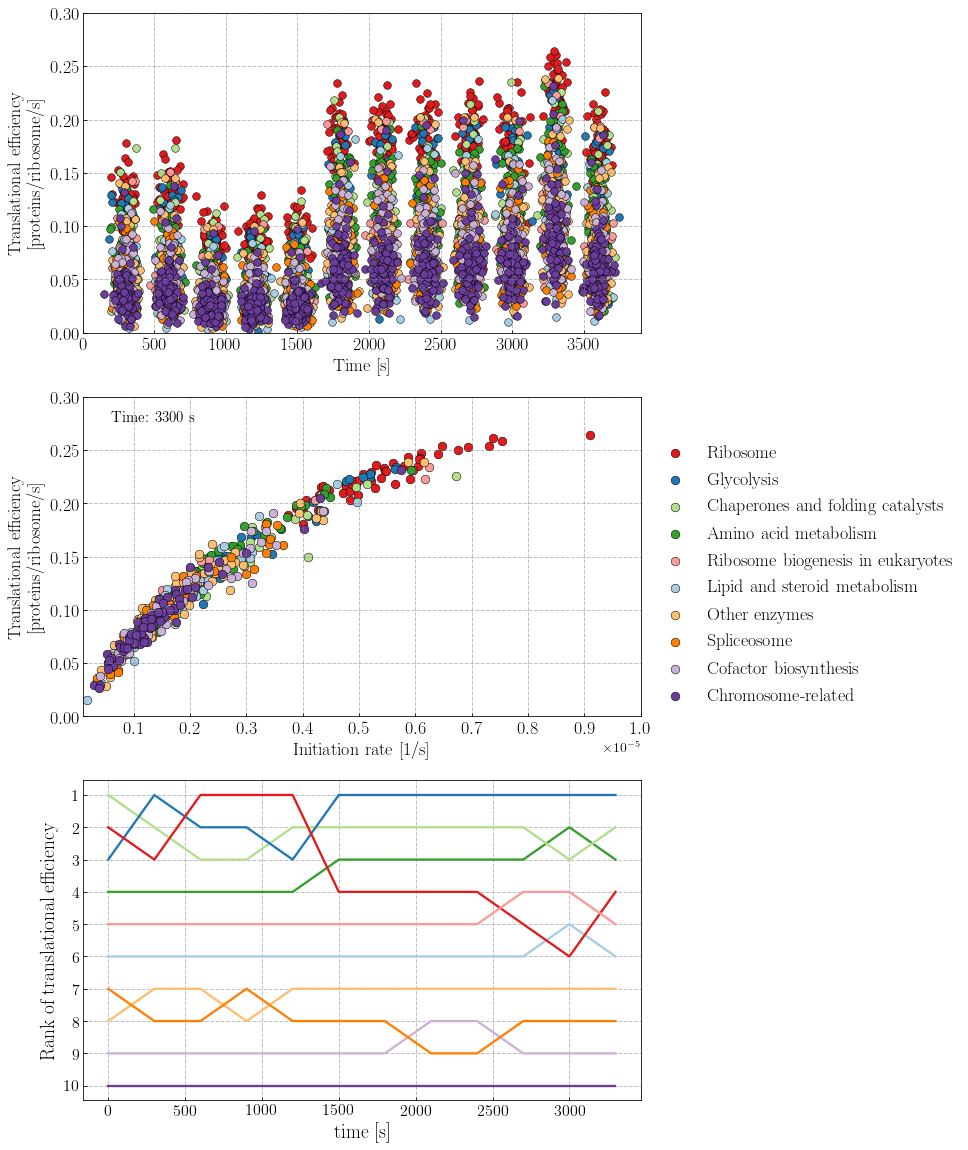

In [93]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams['figure.figsize'] = (10, 20)

fig =  plt.figure()                
#############################################################################################################################
ax = fig.add_subplot(311, facecolor='white')

fontsize = 18
markersize = 60

xaxislabel = 'Time [s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

for function, _ in sorted_functions:
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function, s=markersize, edgecolor='black',
                     rasterized=True)
        scat.set_alpha(1.0)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

shortlabels = list(set(labels))

#plt.text(-350, 0.3, "A", fontsize=24, weight="bold")

#############################################################################################################################
ax = fig.add_subplot(312, facecolor='white')

time = 3000
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

for function, _ in sorted_functions:
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], 
                       c=colordict[function],
                       label=function, 
                       s=75, 
                       edgecolor='black')
    scat.set_alpha(1.0)
    
#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
ax.text(.05, .92, 'Time: 3300 s', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), fontsize=fontsize)
plt.rc('font', **{'size':'24'})

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")
#############################################################################################################################
font = {'size': 16}
matplotlib.rc('font', **font)

ax = fig.add_subplot(313, facecolor='white')

ax.grid(True, linestyle = '-.', color = 'grey')

#ranks.transpose().plot(linewidth=2.3, color=[colordict.get(x, '#333333') for x in ranks.transpose().columns])
for column in ranks.transpose().columns:
    ax.plot(ranks.transpose()[column], linewidth=2.3, color=colordict.get(column, '#333333'))

plt.xlabel('time [s]')
plt.ylabel('Rank of translational efficiency')
plt.gca().invert_yaxis()
plt.gca().set_yticks(range(1, len(ranks) + 1, 1))

#handles, labels = ax.get_legend_handles_labels()
# sort labels
# labels_tmp = ranks.sort_values([1800]).index
# sort handles the same way
# https://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list
# handles_tmp = [x for _, x in sorted(zip(ranks[1800], handles))]

#plt.legend(handles_tmp, labels_tmp, loc='center left', bbox_to_anchor=(0.99, 0.5), labelspacing=0.93, frameon=False)

plt.savefig('time_and_init_rate_resolved_efficiency_ranking.png', bbox_inches='tight', dpi=600)
#plt.savefig('time_and_init_rate_resolved_efficiency.pdf', bbox_inches='tight', dpi=400)
#plt.savefig('time_and_init_rate_resolved_efficiency.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()